# Swimming of a _P. dumerilii_ larva as a function of the wavelength of its metachronal wave.

We simulated a model of a _Platynaereis dumerilii_ larva, represented as a sphere with a single ring of cilia around it. A real _P. dumerilii_ larva has a diameter of approximately $160 \mu\mathrm{m}$ and cilia of approximately $20 \mu\mathrm{m}$ in length, and so we set the ratio between the diameter of the sphere and the cilium length to $8$. The simulations were ran for a total of one period (which all cilia share, thus giving the entirety of the information available) with $500$ timesteps ($\Delta t = 0.002$). The cilia beat with the same frequency, corresponding to a period of $T$. The _P. dumerilii_ model swims freely in a Stokesian fluid of viscosity $\mu$.

The sphere radius is set to $a$, setting the length scale. All $309$ cilia were discretised with $20$ segments, and the sphere itself was discretised with $9000$ blobs. This discretisation sets the length of a cilium to $L = 49.4a$, which gives a sphere of $395.2a$ units in diameter, stretching from $-197.6a$ to $197.6a$ in each direction. Its circumference is therefore approximately $1241.5a$. To maintain at least $2a$ units of separation between cilia, we have an upper limit of $309$ cilia to be seeded. It would be $310$ (since $310\cdot 4 = 1240 < 1241.5$), but we set a realistic tilt angle of $12.5$ degrees which demanded more space. Real _P. dumerilii_ have a separation of around $0.4 \mu\mathrm{m}$ between cilia, which corresponds to $0.988a$; a little less than half of the smallest we can set.

The hydrodynamics were resolved using FFCM, with the enclosing domain being $\Omega = [-4000a, 4000a]^3$.

Each simulation sets a metachronal wave around the sphere with a certain wavenumber, or, amount of complete wavelengths. This number $k$ relates to the dimensional wavelength $\lambda$ via
$$
  \lambda = \frac{160\pi \mu\mathrm{m}}{k}
$$
and to the dimensionless wavelength $\frac{\lambda}{L}$ via
$$
  \frac{\lambda}{L} = \frac{395.2\pi}{49.4 k} \text{.}
$$

Real _P. dumerilii_ have a wavelength of around $\lambda \approx 13.2 \mu\mathrm{m}$ which translates to a dimensionless wavelength of around $\frac{\lambda}{L} \approx 0.66$. Throughout this notebook, this value will be highlighted to remark on the real system.

Let's analyse the data by first obtaining all phases, velocities and forces corresponding to the simulations and organising them by wavelength.

In [8]:
import os
import glob

def create_wavenumber_dict():
    # Base path for data directory
    base_path = "../data"
    
    # Dictionary to store wavenumber -> path mappings
    wave_dict = {}
    
    # Common filename pattern
    filename_pattern = "ciliate_309fil_9000blob_8.00R_0.1000torsion_0.2182tilt"
    filename_pattern += "_0.3000f_eff_1.4960theta0_0.0000freqshift_"
    
    # Find all metachronal wave directories
    wave_dirs = glob.glob(os.path.join(base_path, "wave_k*"))
    
    for wave_dir in wave_dirs:
        # Extract k wavenumber from directory name
        k = int(wave_dir.split('k')[-1])
        
        # Find the date subdirectory (most recent if multiple exist)
        date_dirs = glob.glob(os.path.join(wave_dir, "*"))
        if date_dirs:
            latest_date_dir = max(date_dirs)  # Gets the most recent date
            full_path = os.path.join(latest_date_dir, filename_pattern)
            
            # Convert absolute path to relative path
            rel_path = os.path.relpath(full_path, os.path.dirname(os.getcwd()))
            wave_dict[k] = os.path.join('..', rel_path)
    
    return wave_dict

# Create the dictionary
wave_dict = create_wavenumber_dict()

In [10]:
import numpy as np

def create_data_dict(wave_dict):
    # Define file suffixes and their keys
    file_mappings = {
        "body_vel": "body_vels.dat",
        "phase": "true_states.dat", 
        "forces": "seg_forces.dat",
        "velocities": "seg_vels.dat",
        "blob_forces": "blob_forces.dat",
        "blob_references": "blob_references.dat",
    }
    
    # Dictionary to store all data
    data_dict = {}
    
    # For each wavelength
    for k, base_path in wave_dict.items():
        data_dict[k] = {}
        
        # For each data type
        for key, suffix in file_mappings.items():
            full_path = base_path + suffix
            try:
                # Load data from .dat file into numpy array
                data = np.loadtxt(full_path)
                data_dict[k][key] = data
            except FileNotFoundError:
                print(f"Warning: File not found for k={k}, {key}: {full_path}")
                data_dict[k][key] = None
    
    return data_dict

In [11]:
# Create the nested dictionary with data arrays
data_dict = create_data_dict(wave_dict)

# Example of accessing data:
# data_dict[38]["body_vel"] gives numpy array of body velocities for k=38
# data_dict[1]["phase"] gives numpy array of phase data for k=1

In [12]:
def clean_data(data_dict):
    # For each wavenumber
    for k in data_dict:
        if data_dict[k]["blob_forces"] is not None:
            # Drop first column of indices by selecting from index 1 onwards
            data = data_dict[k]["blob_forces"][:, 1:]

            # Reshape to separate forces for each blob
            # Each row will have 9000 sets of 3 values (force per blob)
            # Reshape to (timesteps, 9000 blobs, 3 components)
            reshaped = data.reshape(data.shape[0], 9000, 3)
            
            # Store the blob forces array
            data_dict[k]["blob_forces"] = reshaped

        if data_dict[k]["blob_references"] is not None:
            # Reshape to separate position of each blob
            # There is only one row of 9000*3 values
            # Reshape to (9000 blobs, 3 components)
            reshaped = data_dict[k]["blob_references"].reshape(9000, 3)
            
            # Store the array
            data_dict[k]["blob_references"] = reshaped

        if data_dict[k]["phase"] is not None:
            # Drop first two columns by selecting from index 2 onwards
            data_dict[k]["phase"] = data_dict[k]["phase"][:, 2:]

        if data_dict[k]["body_vel"] is not None:
            # Extract data array
            data = data_dict[k]["body_vel"]
            
            # Drop first column (index) and split into linear and angular
            # velocities
            linear_vel = data[:, 1:4]   # Columns 1,2,3 for linear velocity
            angular_vel = data[:, 4:7]   # Columns 4,5,6 for angular velocity
            
            # Replace original data with dictionary containing separated
            # components
            data_dict[k]["body_vel"] = {
                "linear": linear_vel,
                "angular": angular_vel
            }
        if data_dict[k]["forces"] is not None:
            # Extract data array and drop first column (index)
            data = data_dict[k]["forces"][:, 1:]
            
            # Reshape to separate forces and torques
            # Each row will have 309*20 sets of 6 values (force + torque per
            # segment) Reshape to (timesteps, 309 cilia, 20 segments,
            # 6 components)
            reshaped = data.reshape(data.shape[0], 309, 20, 6)
            
            # Keep only force vectors (first 3 components)
            forces = reshaped[:, :, :, :3]
            
            # Store the forces array (shape: timesteps, 309 cilia, 20 segments,
            # 3 components)
            data_dict[k]["forces"] = forces

        if data_dict[k]["velocities"] is not None:
            # Extract data array and drop first column (index)
            data = data_dict[k]["velocities"][:, 1:]
            
            # Reshape to separate velocities and angular velocities
            # Each row will have 309*20 sets of 6 values (velocity + angular
            # velocity per segment) Reshape to (timesteps, 309 cilia,
            # 20 segments, 6 components)
            reshaped = data.reshape(data.shape[0], 309, 20, 6)
            
            # Keep only velocity vectors (first 3 components)
            velocities = reshaped[:, :, :, :3]
            
            # Store the velocities array (shape: timesteps, 309 cilia,
            # 20 segments, 3 components)
            data_dict[k]["velocities"] = velocities
    
    return data_dict
    
# Clean the phase data
data_dict_clean = clean_data(data_dict)

# Now:

# data_dict_clean[k]["phase"] contains only the relevant cilia phase data
# Each row has 309 values, one for each cilium

# data_dict_clean[k]["body_vel"] contains:
# - "linear": numpy array with shape (timesteps, 3) for linear velocity
# components
# - "angular": numpy array with shape (timesteps, 3) for angular velocity
# components

# data_dict_clean[k]["forces"][t, c, s] is the 3-vector containing the force of
# the s-th segment of the c-th cilium at time t

# data_dict_clean[k]["velocities"][t, c, s] is the 3-vector containing the
# velocity of the s-th segment of the c-th cilium at time t

In [13]:
def compute_blob_velocities(data_dict):
    """Compute blob velocities from body motion and reference positions."""
    for k in data_dict:
        if (data_dict[k]["body_vel"] is not None and 
            data_dict[k]["blob_references"] is not None):
            
            # Extract data
            body_vel = data_dict[k]["body_vel"]["linear"]  # (timesteps, 3)
            angular_vel = data_dict[k]["body_vel"]["angular"]  # (timesteps, 3)
            blob_refs = data_dict[k]["blob_references"]  # (9000, 3)
            
            # Initialize array for blob velocities
            # Shape: (timesteps, 9000 blobs, 3 components)
            timesteps = body_vel.shape[0]
            blob_vels = np.zeros((timesteps, 9000, 3))
            
            # For each timestep
            for t in range(timesteps):
                # Broadcast body velocity to all blobs
                blob_vels[t] = body_vel[t]  # Broadcasting adds velocity to all
                # blobs
                
                # Add angular contribution: ω × r
                # Using cross product for each blob
                # The blob reference works because the body is initialised at
                # the origin
                cross_products = np.cross(angular_vel[t], blob_refs)
                blob_vels[t] += cross_products
            
            # Store in data dictionary
            data_dict[k]["blob_velocities"] = blob_vels
    
    return data_dict

data_dict_clean = compute_blob_velocities(data_dict_clean)

# Now data_dict[k]["blob_velocities"][t,b] gives the velocity vector of blob b
# at time t

In [14]:
time = np.linspace(0, 1, data_dict_clean[1]["phase"].shape[0])

In [ ]:
def add_uniform_case(wave_dict, data_dict_clean=None):
    """
    Add the uniform/synchronized case (k=0) to the existing wavelength dictionary
    """
    # Base path for uniform case
    uniform_path = "../data/wave_uniform"
    
    # Common filename pattern (same as in create_wavenumber_dict)
    filename_pattern = "ciliate_309fil_9000blob_8.00R_0.1000torsion_0.2182tilt"
    filename_pattern += "_0.3000f_eff_1.4960theta0_0.0000freqshift_"
    
    # Find the date subdirectory (most recent if multiple exist)
    date_dirs = glob.glob(os.path.join(uniform_path, "*"))
    if date_dirs:
        latest_date_dir = max(date_dirs)  # Gets the most recent date
        full_path = os.path.join(latest_date_dir, filename_pattern)
        
        # Convert absolute path to relative path
        rel_path = os.path.relpath(full_path, os.path.dirname(os.getcwd()))
        
        # Add to dictionary with key 0 (representing k=0 for synchronized case)
        wave_dict[0] = os.path.join('..', rel_path)
        
        # If data_dict_clean is provided, also process the data
        if data_dict_clean is not None:
            # Create data for this case
            sync_data = create_data_dict({0: wave_dict[0]})[0]
            
            # Clean the data using the same cleaning function
            temp_dict = {0: sync_data}
            clean_temp = clean_data(temp_dict)
            
            # Process blob velocities
            compute_blob_velocities(clean_temp)
            
            # Add the cleaned data to data_dict_clean
            data_dict_clean[0] = clean_temp[0]
    else:
        print("Warning: No synchronized case directory found")
    
    return wave_dict, data_dict_clean

# Use the function to add the uniform case
wave_dict, data_dict_clean = add_uniform_case(wave_dict, data_dict_clean)

In [ ]:
def add_random_cases(wave_dict):
    """
    Process random phase cases and store them in a separate dictionary
    for flexible averaging in plots.
    """
    # Base path pattern for random cases
    random_path_pattern = "../data/prescribed_random_"
    
    # Common filename pattern
    filename_pattern = "ciliate_309fil_9000blob_8.00R_0.1000torsion_0.2182tilt"
    filename_pattern += "_0.3000f_eff_1.4960theta0_0.0000freqshift_"
    
    # Find all random case directories
    random_dirs = glob.glob(random_path_pattern)
    
    # Dictionary to store all random cases
    random_data_dict = {}
    
    # Process each random directory
    for i, rand_dir in enumerate(sorted(random_dirs)):
        # Find the date subdirectory (most recent if multiple exist)
        date_dirs = glob.glob(os.path.join(rand_dir, "*"))
        if date_dirs:
            latest_date_dir = max(date_dirs)  # Gets the most recent date
            full_path = os.path.join(latest_date_dir, filename_pattern)
            
            # Convert absolute path to relative path
            rel_path = os.path.relpath(full_path, os.path.dirname(os.getcwd()))
            
            # Add to wave dictionary with unique key
            key = f'rand_{i}'
            wave_dict[key] = os.path.join('..', rel_path)
            
            # Create data for this case
            rand_data = create_data_dict({key: wave_dict[key]})[key]
            
            # Clean the data
            temp_dict = {key: rand_data}
            clean_temp = clean_data(temp_dict)
            
            # Process blob velocities
            compute_blob_velocities(clean_temp)
            
            # Store the processed data
            random_data_dict[i] = clean_temp[key]
        else:
            print(f"Warning: No date directory found in {rand_dir}")
    
    print(f"Processed {len(random_data_dict)} random phase cases")
    return wave_dict, random_data_dict

# Use the function to add the random cases
wave_dict, random_data_dict = add_random_cases(wave_dict)

Processed 0 random phase cases


We first study the speed of the swimmer in time with decreasing wavelength.

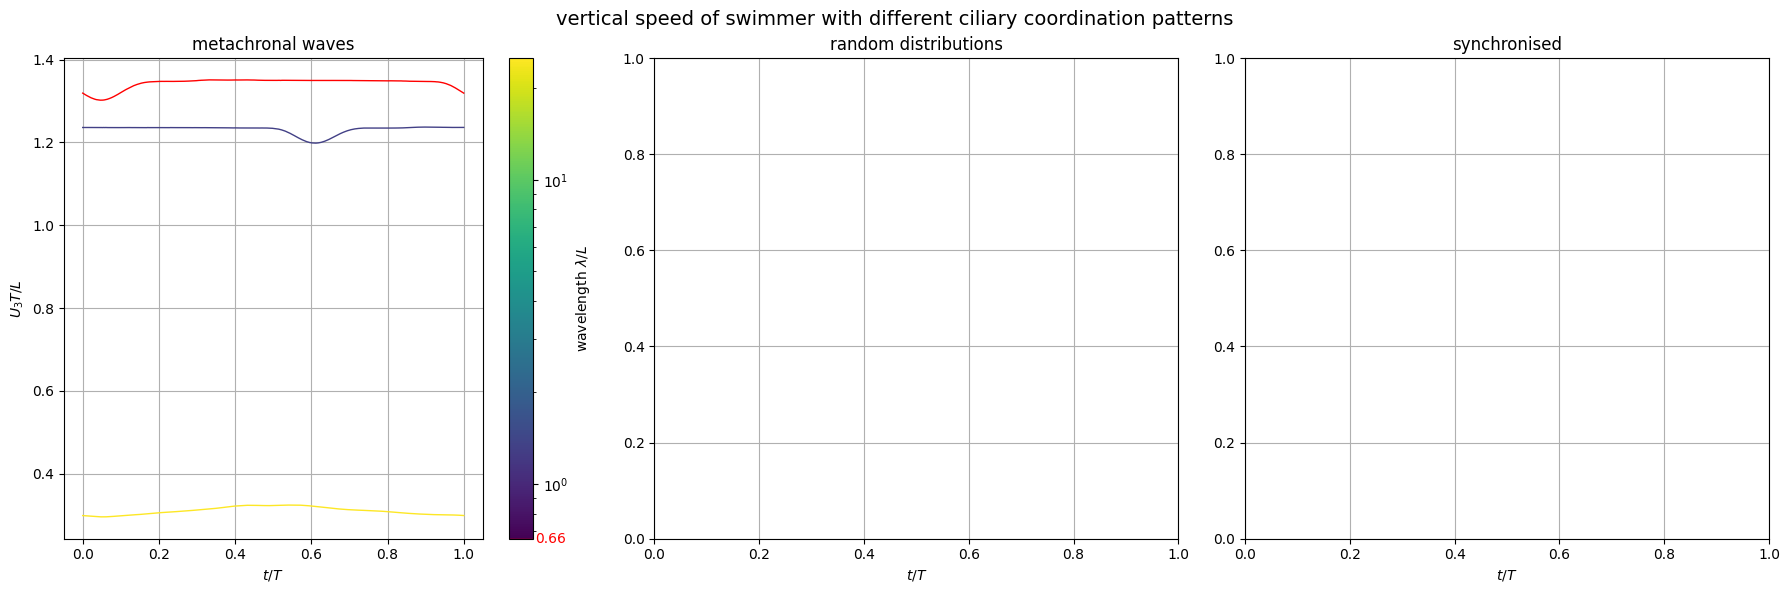

In [17]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

def plot_speed_vs_time(data_dict, random_data_dict):
    # Create figure with 3 side-by-side subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Get the list of wavenumbers and sort them
    wavenumbers = [k for k in data_dict.keys() if isinstance(k, int) and k > 0]
    wavenumbers.sort()
    wavelengths = [np.pi * 395.2 / 49.4 / k for k in wavenumbers]
    
    # Calculate the wavelength for k=38 (real P. dumerilii)
    k38_wavelength = np.pi * 395.2 / 49.4 / 38
    
    # Normalize the wavenumbers to [0, 1] for colormap
    norm = LogNorm(vmin=min(wavelengths), vmax=max(wavelengths))
    cmap = plt.get_cmap('viridis')
    
    # --- SUBPLOT 1: Wave cases ---
    ax = axes[0]
    
    # Plot the regular wave cases
    for k in wavenumbers:
        data = data_dict[k]
        vertical_speed = data["body_vel"]["linear"][:, 2]/49.4
        wavelength = wavelengths[wavenumbers.index(k)]
        color = 'red' if k == 38 else cmap(norm(wavelength))
        ax.plot(time, vertical_speed, color=color, linewidth=1)
    
    ax.set_xlabel(r'$t/T$')
    ax.set_ylabel(r'$U_3 T/L$')
    ax.set_title('metachronal waves')
    ax.grid(True)
    
    # Add colorbar for wavelengths
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label(r'wavelength $\lambda/L$')
    
    # Highlight k=38 in the colorbar
    k38_norm_pos = norm(k38_wavelength)
    cbar.ax.plot([0, 1], [k38_norm_pos, k38_norm_pos], 'r', linewidth=1, transform=cbar.ax.transAxes)
    cbar.ax.text(1.1, k38_norm_pos, '0.66', color='red', va='center', ha='left', transform=cbar.ax.transAxes)
    
    # --- SUBPLOT 2: Random cases ---
    ax = axes[1]
    
    # Process random cases
    if random_data_dict:
        random_speeds = []
        
        # Calculate speed for each random sample
        for i, rand_data in random_data_dict.items():
            vert_speed = rand_data["body_vel"]["linear"][:, 2]/49.4
            random_speeds.append(vert_speed)
            
            # Plot individual random samples with low opacity
            ax.plot(time, vert_speed, color='black', alpha=0.5, linewidth=0.5)
        
        # Calculate mean and standard deviation for random speeds
        random_speeds_array = np.array(random_speeds)
        mean_speed = np.mean(random_speeds_array, axis=0)
        std_speed = np.std(random_speeds_array, axis=0)
        
        # Add standard deviation as a gray area
        ax.fill_between(
            time, 
            mean_speed - std_speed, 
            mean_speed + std_speed, 
            color='gray', 
            alpha=0.3,
            label='±1σ'
        )
        
        # Plot the mean with a thick line
        ax.plot(time, mean_speed, color='black', linewidth=2, linestyle='-',
                label='mean')
        
        ax.legend(loc='upper right')
    
    ax.set_xlabel(r'$t/T$')
    ax.set_title('random distributions')
    ax.grid(True)
    
    # --- SUBPLOT 3: Synchronized case (k=0) ---
    ax = axes[2]
    
    # Plot the synchronized case (k=0)
    if 0 in data_dict:
        vertical_speed_uniform = data_dict[0]["body_vel"]["linear"][:, 2]/49.4
        ax.plot(
            time, vertical_speed_uniform, color='black', linewidth=1,
            linestyle='-',
        )
        
        ax.legend(loc='upper right')
    
    ax.set_xlabel(r'$t/T$')
    ax.set_title('synchronised')
    ax.grid(True)
    
    # Common title for all subplots
    fig.suptitle('vertical speed of swimmer with different ciliary coordination patterns', fontsize=14)
    
    # Adjust layout
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)  # Make room for suptitle
    
    plt.show()

# Call the function with both dictionaries
plot_speed_vs_time(data_dict_clean, random_data_dict)

Looks like decreasing the wavelength increases swimming speed up to a point, and the actual swimming speed is near the saturation. It also looks like the case corresponding to the real wavelength is smoother than its neighbours. Notably, the lower wavelengths outperform all random scenarios (N=12). The fully synchronised case, as expected, reaches a much higher speed in the effective stroke, while going backwards in the recovery.

The entire isn't perfectly axisymmetric, so it wobbles. Let's study the wobbling too to see if its relationship to wavelength is meaningful.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


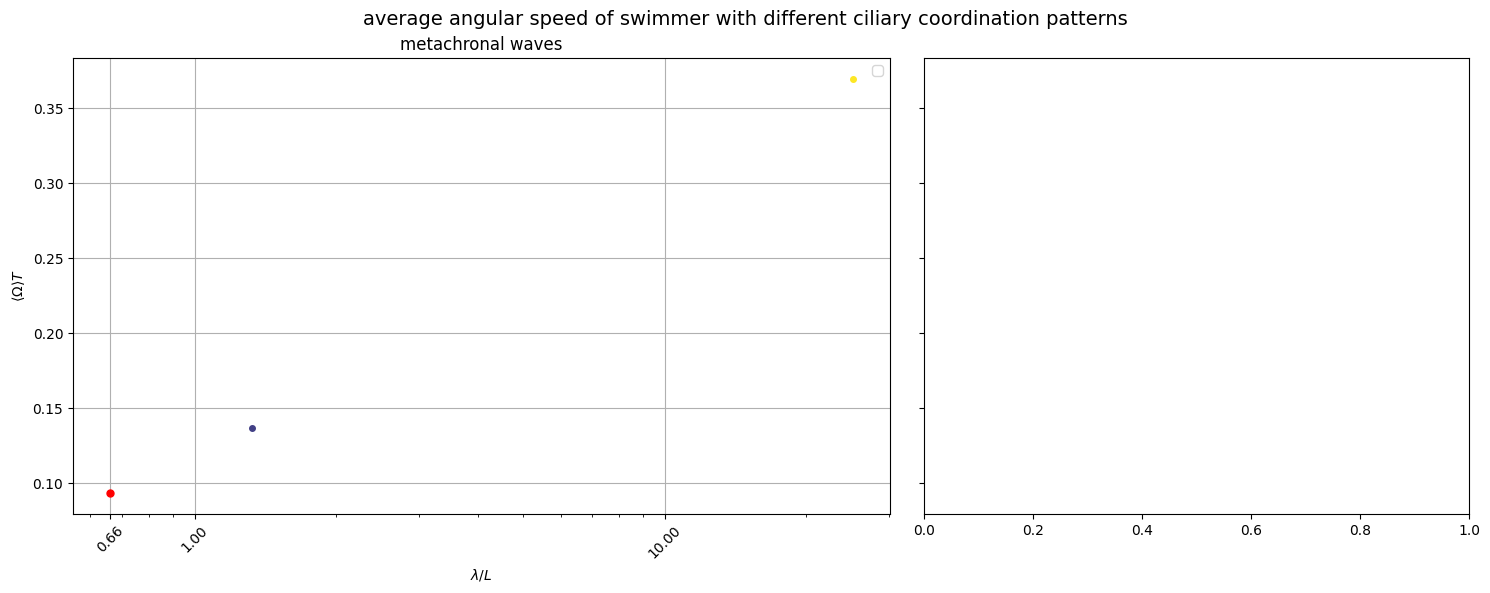

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from scipy import stats

def plot_avg_wobble_vs_wavelength(data_dict, random_data_dict):
    # Create figure with 2 subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), 
                                  gridspec_kw={'width_ratios': [1.5, 1]},
                                  sharey=True)
    
    # --- MAIN PLOT: Wavelength vs Angular Speed ---
    avg_speeds = []
    wavelengths = []
    wavenumbers = []
    
    # Process regular wave cases
    for k, data in data_dict.items():
        if isinstance(k, int) and k > 0 and data["body_vel"] is not None:
            # Calculate the norm of the angular velocity
            speed = np.linalg.norm(data["body_vel"]["angular"], axis=1)
            avg_speed = np.mean(speed)
            avg_speeds.append(avg_speed)
            wavelength = np.pi * 395.2 / 49.4 / k
            wavelengths.append(wavelength)
            wavenumbers.append(k)
    
    # Calculate the wavelength for k=38
    k38_wavelength = np.pi * 395.2 / 49.4 / 38
    
    # Create color mapping
    norm = LogNorm(vmin=min(wavelengths), vmax=max(wavelengths))
    cmap = plt.get_cmap('viridis')
    
    # Plot points with colors based on wavelength
    for k, wavelength, speed in zip(wavenumbers, wavelengths, avg_speeds):
        if k == 38:
            ax1.plot(wavelength, speed, 'r.', markersize=10)
        else:
            color = cmap(norm(wavelength))
            ax1.plot(wavelength, speed, '.', color=color, markersize=8)

    # Set log scale for x-axis
    ax1.set_xscale('log')

    # Get the default ticks that matplotlib would generate
    locs = ax1.get_xticks()
    
    # Add k=38 wavelength to the ticks
    locs = np.append(locs, np.pi * 395.2 / 49.4 / 38)
    locs = np.sort(locs)
    
    # Filter the locs so that only values between 0.2 and 25 are kept
    locs = locs[(locs >= 0.2) & (locs <= 25)]
    
    # Format the tick labels
    labels = [f'{loc:.2f}' for loc in locs]
    
    # Set the updated ticks and labels
    ax1.set_xticks(locs)
    ax1.set_xticklabels(labels, rotation=45)
    
    # Get the default ticks that matplotlib would generate
    ax1.set_xlabel(r'$\lambda/L$')
    ax1.set_ylabel(r'$\langle\Omega\rangle T$')
    ax1.set_title('metachronal waves')
    ax1.grid(True)
    ax1.legend(loc='best')
    
    # --- SIDE PLOT: Random Distribution ---
    if random_data_dict:
        random_avg_speeds = []
        
        # Calculate average angular speed for each random sample
        for i, rand_data in random_data_dict.items():
            if rand_data["body_vel"] is not None:
                speed = np.linalg.norm(rand_data["body_vel"]["angular"], axis=1)
                avg_speed = np.mean(speed)
                random_avg_speeds.append(avg_speed)
        
        # Convert to numpy array
        random_avg_speeds = np.array(random_avg_speeds)
        
        # Calculate mean and std of random angular speeds
        mean_random = np.mean(random_avg_speeds)
        std_random = np.std(random_avg_speeds)
        
        # Calculate kernel density estimation for a smooth distribution
        if len(random_avg_speeds) >= 3:  # Need at least a few points for kernel density
            density = stats.gaussian_kde(random_avg_speeds)
            xs = np.linspace(min(random_avg_speeds) - 0.1*std_random, 
                            max(random_avg_speeds) + 0.1*std_random, 100)
            ys = density(xs)
            
            # Plot the distribution horizontally (violin plot style)
            ax2.fill_betweenx(xs, 0, ys, color='gray', alpha=0.5)
        
        # # Plot individual data points on the side
        # ax2.plot(np.zeros_like(random_avg_speeds) + 0.01, random_avg_speeds, 
        #         'o', color='black', alpha=0.5, markersize=6)
        
        # Add line for mean
        ax2.axhline(mean_random, color='black', linestyle='-.', linewidth=2, 
                   label=f'random mean')
        
        ax2.set_title('random distribution and synchronised case')
        ax2.set_xticks([])  # Hide x-axis ticks
        ax2.grid(True, axis='y')
        ax2.set_xlabel('density')

        # Add synchronized case as a horizontal line in the distribution plot
        if 0 in data_dict and data_dict[0]["body_vel"] is not None:
            sync_speed = np.linalg.norm(data_dict[0]["body_vel"]["angular"], axis=1)
            sync_avg_speed = np.mean(sync_speed)
            
            ax2.axhline(sync_avg_speed, color='black', linestyle='-', linewidth=2, 
                      label='synchronised')
        
        # Set axis limits
        if len(random_avg_speeds) >= 3:
            ax2.set_xlim(0, max(ys)*1.2)

        ax2.legend()
        
    # Common title for all subplots
    fig.suptitle('average angular speed of swimmer with different ciliary coordination patterns', fontsize=14)
    
    # Adjust layout
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)  # Make room for suptitle
    plt.subplots_adjust(wspace=0.05)  # Reduce space between subplots
    
    plt.show()

# Call the function with both dictionaries
plot_avg_wobble_vs_wavelength(data_dict_clean, random_data_dict)

It seems that wobbling is minimised with wavelength, but with no apparent saturation. It is interesting that the very next wavelength after the system has higher wobbling: maybe it's a local minima. The random phase distributions seem to be clustered strongly around a value very close to the realistic case. The synchronised case exhibits almost no wobbling (as expected: any amount is due to discretisation error if the expect the ideal system to be axisymmetric). Now we look at the average speed and top speed as a function of wavelength.

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


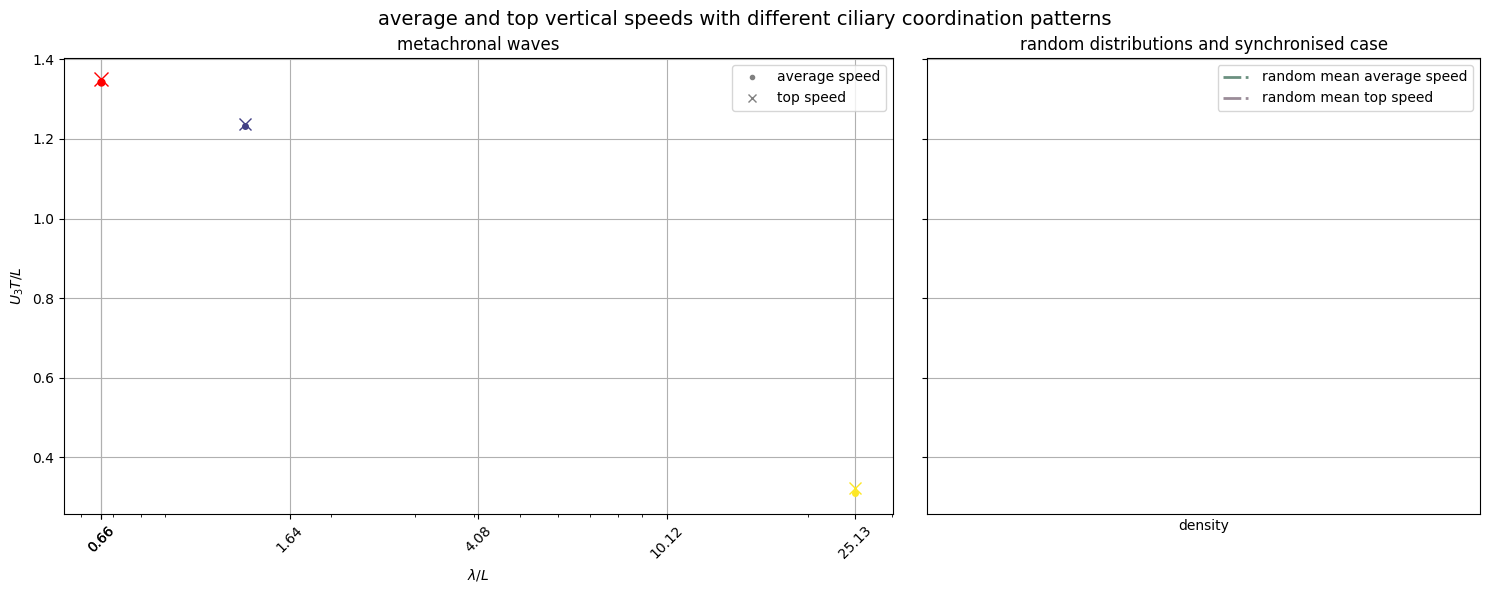

In [19]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

def plot_avg_and_top_speed_vs_wavelength(data_dict, random_data_dict):
    # Create figure with 2 subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), 
                                  gridspec_kw={'width_ratios': [1.5, 1]},
                                  sharey=True)
    
    # --- MAIN PLOT: Wavelength vs Speeds ---
    avg_speeds = []
    top_speeds = []
    wavelengths = []
    wavenumbers = []
    
    # Process regular wave cases
    for k, data in data_dict.items():
        if isinstance(k, int) and k > 0 and data["body_vel"] is not None:
            # Calculate speeds from linear velocity
            speed = data["body_vel"]["linear"][:, 2]/49.4
            avg_speed = np.mean(speed)
            top_speed = np.max(speed)
            
            avg_speeds.append(avg_speed)
            top_speeds.append(top_speed)
            wavelength = np.pi * 395.2 / 49.4 / k
            wavelengths.append(wavelength)
            wavenumbers.append(k)
    
    # Calculate the wavelength for k=38
    k38_wavelength = np.pi * 395.2 / 49.4 / 38
    
    # Create color mapping
    norm = LogNorm(vmin=min(wavelengths), vmax=max(wavelengths))
    cmap = plt.get_cmap('viridis')
    
    # Plot average and top speeds
    for k, wavelength, avg_speed, top_speed in zip(wavenumbers, wavelengths, avg_speeds, top_speeds):
        if k == 38:
            ax1.plot(wavelength, avg_speed, 'r.', markersize=10)
            ax1.plot(wavelength, top_speed, 'rx', markersize=10)
        else:
            color = cmap(norm(wavelength))
            ax1.plot(wavelength, avg_speed, '.', color=color, markersize=8)
            ax1.plot(wavelength, top_speed, 'x', color=color, markersize=8)
    
    # Set log scale for x-axis
    ax1.set_xscale('log')
    
    # Get the default ticks that matplotlib would generate
    ax1.set_xticks([])  # Clear current ticks
    ax1.set_xticks(np.logspace(np.log10(min(wavelengths)), np.log10(max(wavelengths)), 5))
    
    # Add k=38 wavelength to the ticks
    locs = list(ax1.get_xticks())
    locs.append(k38_wavelength)
    locs = sorted(locs)
    
    # Format the tick labels
    ax1.set_xticks(locs)
    ax1.set_xticklabels([f'{loc:.2f}' for loc in locs], rotation=45)
    
    ax1.set_xlabel(r'$\lambda/L$')
    ax1.set_ylabel(r'$U_3 T/L$')
    ax1.set_title('metachronal waves')
    ax1.grid(True)
    
    # Add legend for circle/cross markers
    ax1.plot([], [], '.', color='gray', label=r'average speed')
    ax1.plot([], [], 'x', color='gray', label=r'top speed')
    ax1.legend(loc='best')
    
    # --- SIDE PLOT: Random Distribution ---
    # Collect random data
    random_avg_speeds = []
    random_top_speeds = []
    
    # Calculate speeds for each random sample
    for i, rand_data in random_data_dict.items():
        if rand_data["body_vel"] is not None:
            speed = rand_data["body_vel"]["linear"][:, 2]/49.4
            avg_speed = np.mean(speed)
            top_speed = np.max(speed)
            random_avg_speeds.append(avg_speed)
            random_top_speeds.append(top_speed)
    
    # Convert to numpy arrays
    random_avg_speeds = np.array(random_avg_speeds)
    random_top_speeds = np.array(random_top_speeds)
    
    # Calculate means
    mean_avg_speed = np.mean(random_avg_speeds)
    mean_top_speed = np.mean(random_top_speeds)

    std_avg_speed = np.std(random_avg_speeds)
    std_top_speed = np.std(random_top_speeds)
    
    # Use more subtle colors
    avg_color = '#6b9080'  # muted teal
    top_color = '#9a8c98'  # muted purple
    
    # Calculate kernel density estimation for smooth distributions
    if len(random_avg_speeds) >= 3:
        # Calculate densities
        density_avg = stats.gaussian_kde(random_avg_speeds)
        density_top = stats.gaussian_kde(random_top_speeds)
        
        # Create x-range for evaluation
        xs_avg = np.linspace(min(random_avg_speeds) - 0.1*std_avg_speed,
                             max(random_avg_speeds) + 0.1*std_avg_speed, 100)
        xs_top = np.linspace(min(random_top_speeds) - 0.1*std_top_speed,
                            max(random_top_speeds) + 0.1*std_top_speed, 100)
        
        ys_avg = density_avg(xs_avg)
        ys_top = density_top(xs_top)
        
        # Plot the distributions as filled curves
        ax2.fill_betweenx(xs_avg, 0, ys_avg, color=avg_color, alpha=0.5, label='random average speed')
        ax2.fill_betweenx(xs_top, 0, ys_top, color=top_color, alpha=0.5, label='random top speed')
    
    # Add mean lines for random distributions
    ax2.axhline(mean_avg_speed, color=avg_color, linestyle='-.', linewidth=2, label='random mean average speed')
    ax2.axhline(mean_top_speed, color=top_color, linestyle='-.', linewidth=2, label='random mean top speed')
    
    # Add synchronized case as horizontal lines (if available)
    if 0 in data_dict and data_dict[0]["body_vel"] is not None:
        sync_speed = data_dict[0]["body_vel"]["linear"][:, 2]/49.4
        sync_avg_speed = np.mean(sync_speed)
        sync_top_speed = np.max(sync_speed)
        
        # Add horizontal lines
        ax2.axhline(sync_avg_speed, color=avg_color, linestyle='-', linewidth=2, label='synchronised average speed')
        ax2.axhline(sync_top_speed, color=top_color, linestyle='-', linewidth=2, label='synchronised top speed')
    
    ax2.set_title('random distributions and synchronised case')
    ax2.grid(True, axis='y')
    ax2.set_xlabel('density')
    ax2.set_xticks([])  # Hide x-axis ticks

    # Set axis limits
    if len(random_avg_speeds) >= 3:
        ax2.set_xlim(0, max(ys_avg)*1.2)
    
    # Legend for distributions
    ax2.legend(loc='upper right')
    
    # Common title
    fig.suptitle('average and top vertical speeds with different ciliary coordination patterns', fontsize=14)
    
    # Adjust layout
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)  # Make room for suptitle
    plt.subplots_adjust(wspace=0.05)  # Reduce space between subplots
    
    plt.show()

# Call the function with both dictionaries
plot_avg_and_top_speed_vs_wavelength(data_dict_clean, random_data_dict)

Here it seems that the real wavelength might be close to a local maxima for both average and top speeds, althout there is a higher value with smaller wavelength. The random and synchronised cases both underperform greatly when looking at average speeds. The distribution of top speeds in the random case is a lot more spread than the localised average speed. Predictably, the top speed of the synchronised case is the highest, but its average speed is close to the worst wave cases. The random top speed is higher but on the order of metachronal wave top speeds.

Then we study the energy dissipation of the swimmer in time with decreasing wavelength, the total energy dissipation as a function of wavelength and the average energy dissipation as a function of wavelength.

In [20]:
def compute_energy_dissipation(data_dict):
    energy_dissipation = {}

    for k, data in data_dict.items():
        if data["forces"] is not None and data["velocities"] is not None:
            # Compute energy dissipation for segments

            # Shape: (timesteps, 309 cilia, 20 segments, 3 components)
            segment_forces = data["forces"]
            # Shape: (timesteps, 309 cilia, 20 segments, 3 components)
            segment_velocities = data["velocities"]/49.4  # Normalize by L
            # Dot product along last axis
            segment_dissipation = np.sum(segment_forces*segment_velocities, axis=-1)
            # Sum over cilia and segments
            total_segment_dissipation = np.sum(segment_dissipation, axis=(1, 2))

            # Compute energy dissipation for blobs if available
            if data["blob_forces"] is not None and data["blob_velocities"] is not None:
                # Shape: (timesteps, 9000 blobs, 3 components)
                blob_forces = data["blob_forces"]
                # Shape: (timesteps, 9000 blobs, 3 components)
                blob_velocities = data["blob_velocities"]/49.4  # Normalize by L
                # Dot product along last axis
                blob_dissipation = np.sum(blob_forces*blob_velocities, axis=-1)
                # Sum over blobs
                total_blob_dissipation = np.sum(blob_dissipation, axis=1)
            else:
                total_blob_dissipation = np.zeros_like(total_segment_dissipation)

            # Total energy dissipation
            total_dissipation = total_segment_dissipation + total_blob_dissipation
            energy_dissipation[k] = total_dissipation

    return energy_dissipation

# Compute energy dissipation for regular cases and synchronized case
energy_dissipation = compute_energy_dissipation(data_dict_clean)

# Compute energy dissipation for random cases
random_energy_dissipation = compute_energy_dissipation(random_data_dict)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


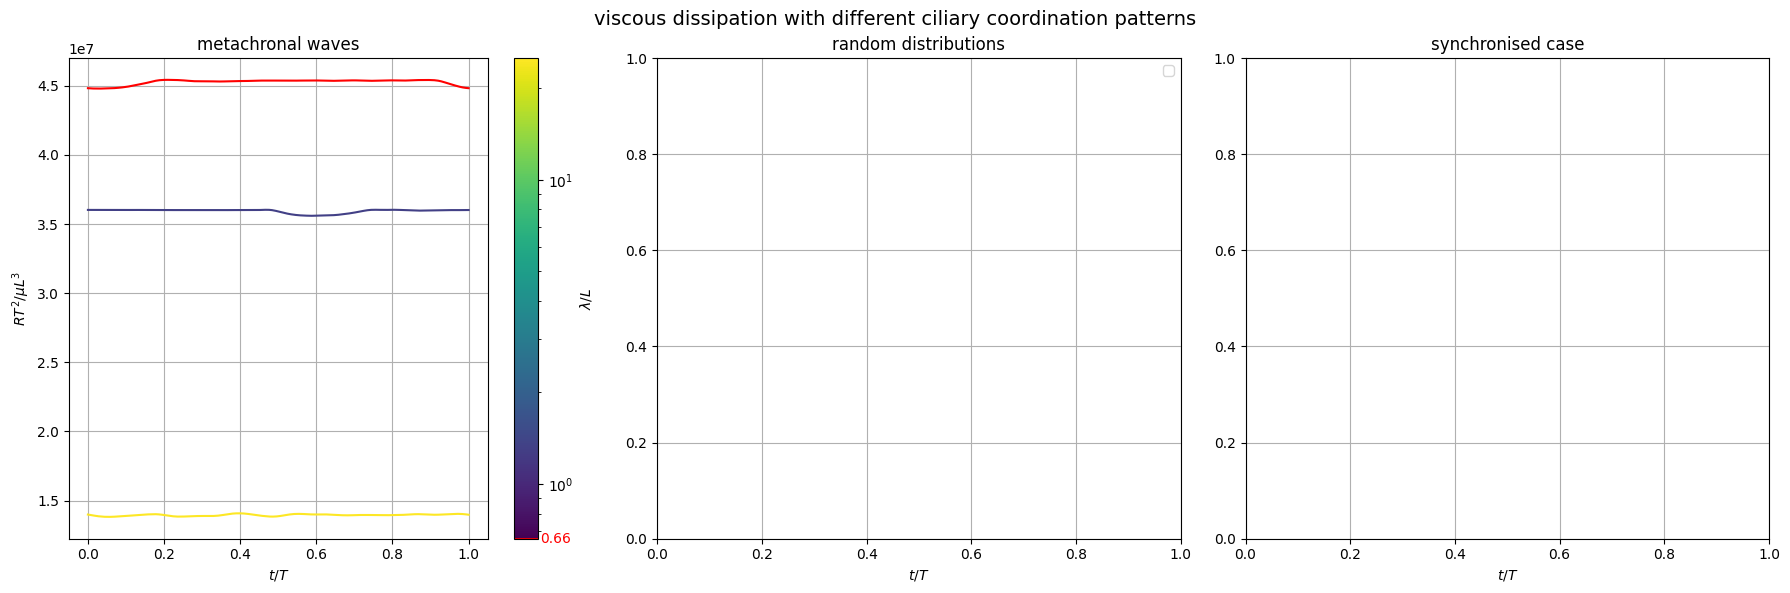

In [21]:
def plot_energy_dissipation(energy_dissipation, random_energy_dissipation, time):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    
    # --- MAIN PLOT: Wavelength vs Energy Dissipation ---
    # Get the list of wavenumbers and sort them
    wavenumbers = [k for k in energy_dissipation.keys() if isinstance(k, int) and k > 0]
    wavenumbers.sort()
    wavelengths = [np.pi * 395.2 / 49.4 / k for k in wavenumbers]
    
    # Calculate the wavelength for k=38
    wavelength_38 = np.pi * 395.2 / 49.4 / 38
    
    # Normalize the wavenumbers to [0, 1] for colormap
    norm = LogNorm(vmin=min(wavelengths), vmax=max(wavelengths))
    cmap = plt.get_cmap('viridis')
    
    for k in wavenumbers:
        # Calculate the wavelength
        wavelength = np.pi * 395.2 / 49.4 / k
        
        # Get the color for the current wavenumber
        color = 'red' if k == 38 else cmap(norm(wavelength))
        
        # Plot dissipation against time
        ax1.plot(time, energy_dissipation[k], color=color)
    
    ax1.set_xlabel(r'$t/T$')
    ax1.set_ylabel(r'$RT^2/\mu L^3$')
    ax1.set_title('metachronal waves')
    ax1.grid(True)
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax1)
    cbar.set_label(r'$\lambda/L$')
    
    # Add a red marker for k=38 in the colorbar
    k38_norm_pos = norm(wavelength_38)
    cbar.ax.plot([0, 1], [k38_norm_pos, k38_norm_pos], 'r', linewidth=2, transform=cbar.ax.transAxes)
    cbar.ax.text(1.1, k38_norm_pos, '0.66', color='red', va='center', ha='left', transform=cbar.ax.transAxes)
    
    # --- SIDE PLOT: Random Distribution and Synchronized Case ---
    
    # Plot random cases
    if random_energy_dissipation:
        for i, dissipation in random_energy_dissipation.items():
            # Plot individual random samples with low opacity
            ax2.plot(time, dissipation, color='gray', alpha=0.5, linewidth=0.5)
        
        # Calculate mean and standard deviation
        random_dissipation_array = np.array([diss for diss in random_energy_dissipation.values()])
        mean_dissipation = np.mean(random_dissipation_array, axis=0)
        std_dissipation = np.std(random_dissipation_array, axis=0)
        
        # Plot the mean with a thick line
        ax2.plot(time, mean_dissipation, color='black', linewidth=2, label='random mean')
        
        # Plot standard deviation as a shaded area
        ax2.fill_between(time, mean_dissipation - std_dissipation, 
                         mean_dissipation + std_dissipation,
                         color='gray', alpha=0.3, label='±1σ')
        
    ax2.set_title('random distributions')
    ax2.set_xlabel(r'$t/T$')
    ax2.grid(True)
    ax2.legend()
    
    # Plot synchronized case
    if 0 in energy_dissipation:
        ax3.plot(time, energy_dissipation[0], color='black', linewidth=2, label='synchronised')
    
    ax3.set_xlabel(r'$t/T$')
    ax3.set_title('synchronised case')
    ax3.grid(True)
    
    # Common title for all subplots
    fig.suptitle('viscous dissipation with different ciliary coordination patterns', fontsize=14)
    
    # Adjust layout
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)  # Make room for suptitle
    
    plt.show()

# Plot the energy dissipation vs time
plot_energy_dissipation(energy_dissipation, random_energy_dissipation, time)

Lowering the wavelength seems to make the energy dissipation higher up to a point. It is noteworthy that the actual system seems to have less variance, although this view of dissipation is inherently difficult to read. The dissipation in the syncrhonised case lowers when all cilia are in the middle of the effective stroke, given that they all help each other. Let's take a look at wavelength versus average dissipation (which is the same picture as total energy).

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


UnboundLocalError: local variable 'random_avg_array' referenced before assignment

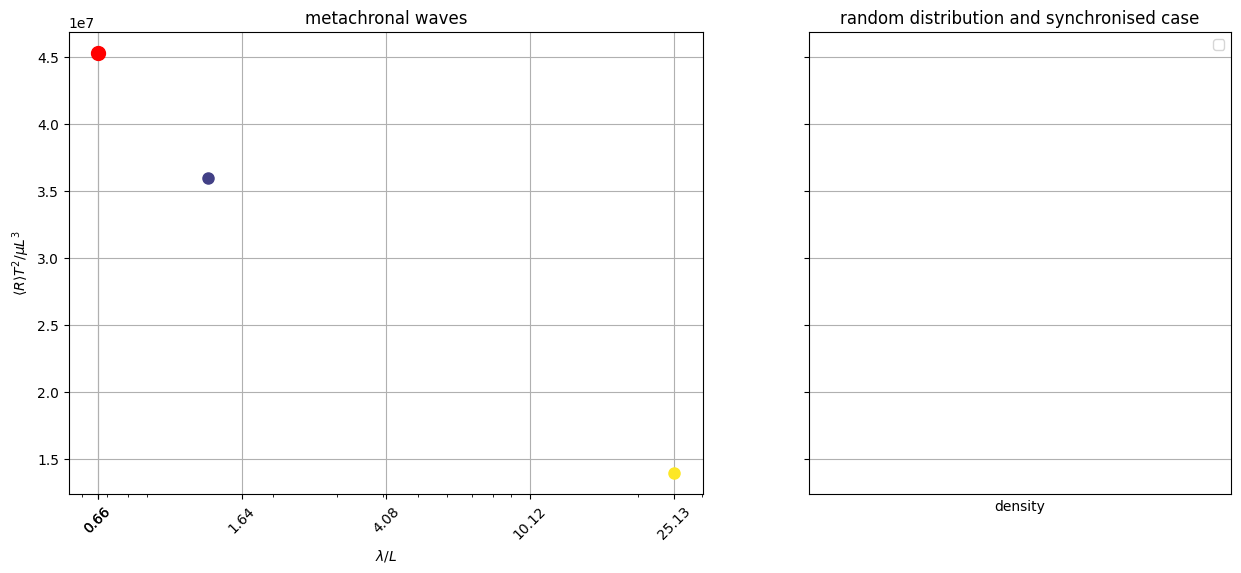

In [22]:
def plot_energy_vs_wavelength(data_dict, energy_dissipation, random_energy_dissipation):
    # Create figure with 2 subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), 
                                  gridspec_kw={'width_ratios': [1.5, 1]},
                                  sharey=True)
    
    # --- MAIN PLOT: Wavelength vs Average Energy ---
    avg_energies = []
    wavelengths = []
    wavenumbers = []
    
    # Process regular wave cases
    for k in data_dict.keys():
        if isinstance(k, int) and k > 0 and k in energy_dissipation:
            # Calculate average energy dissipation
            avg_energy = np.mean(energy_dissipation[k])
            
            avg_energies.append(avg_energy)
            wavelength = np.pi * 395.2 / 49.4 / k
            wavelengths.append(wavelength)
            wavenumbers.append(k)
    
    # Calculate the wavelength for k=38
    wavelength_38 = np.pi * 395.2 / 49.4 / 38
    
    # Create color mapping
    norm = LogNorm(vmin=min(wavelengths), vmax=max(wavelengths))
    cmap = plt.get_cmap('viridis')
    
    # Plot average energies
    for k, wavelength, avg_energy in zip(wavenumbers, wavelengths, avg_energies):
        if k == 38:
            ax1.plot(wavelength, avg_energy, 'ro', markersize=10)
        else:
            color = cmap(norm(wavelength))
            ax1.plot(wavelength, avg_energy, 'o', color=color, markersize=8)
    
    # Set log scale for x-axis
    ax1.set_xscale('log')
    
    # Get the default ticks that matplotlib would generate
    ax1.set_xticks([])  # Clear current ticks
    ax1.set_xticks(np.logspace(np.log10(min(wavelengths)), np.log10(max(wavelengths)), 5))
    
    # Add k=38 wavelength to the ticks
    locs = list(ax1.get_xticks())
    locs.append(wavelength_38)
    locs = sorted(locs)
    
    # Format the tick labels
    ax1.set_xticks(locs)
    ax1.set_xticklabels([f'{loc:.2f}' for loc in locs], rotation=45)
    
    ax1.set_xlabel(r'$\lambda/L$')
    ax1.set_ylabel(r'$\langle R\rangle T^2/\mu L^3$')
    ax1.set_title('metachronal waves')
    ax1.grid(True)
    
    # --- SIDE PLOT: Random Distribution and Synchronized Case ---
    # Process random cases
    if random_energy_dissipation:
        random_avg_energies = [np.mean(diss) for diss in random_energy_dissipation.values()]
        random_avg_array = np.array(random_avg_energies)
        
        # Calculate mean and std
        random_mean = np.mean(random_avg_array)
        random_std = np.std(random_avg_array)
        
        # Calculate kernel density estimation for a smooth distribution
        if len(random_avg_energies) >= 3:
            density = stats.gaussian_kde(random_avg_array)
            xs = np.linspace(min(random_avg_array) - 0.1*random_std, 
                            max(random_avg_array) + 0.1*random_std, 100)
            ys = density(xs)
            
            # Plot the distribution as a filled curve
            ax2.fill_betweenx(xs, 0, ys, color='gray', alpha=0.5, label='random distribution')
        
        # Add mean line for random distribution
        ax2.axhline(random_mean, color='black', linestyle='-.', linewidth=2, 
                   label='random mean')
    
    # Add synchronized case
    if 0 in energy_dissipation:
        sync_avg_energy = np.mean(energy_dissipation[0])
        ax2.axhline(sync_avg_energy, color='black', linestyle='-', linewidth=2, 
                  label='synchronised')
    
    ax2.set_title('random distribution and synchronised case')
    ax2.grid(True, axis='y')
    ax2.set_xlabel('density')
    ax2.set_xticks([])  # Hide x-axis ticks
    ax2.legend()

    # Set axis limits
    if len(random_avg_array) >= 3:
        ax2.set_xlim(0, max(ys)*1.2)
    
    # Common title for all subplots
    fig.suptitle('average dissipation with different ciliary coordination patterns', fontsize=14)
    
    # Adjust layout
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)  # Make room for suptitle
    
    plt.show()

# Plot energy vs wavelength
plot_energy_vs_wavelength(data_dict_clean, energy_dissipation, random_energy_dissipation)

Energy expenditure seems to grow with decreasing wavelength, but saturating at a point close to the realistic wavelength. The syncrhonised case has a low average dissipation (probably due to the extended time in the recovery stroke) while the random cases are clustered lower to the realistic case. Finally we study the hydrodynamic efficiency as a function of wavelength.

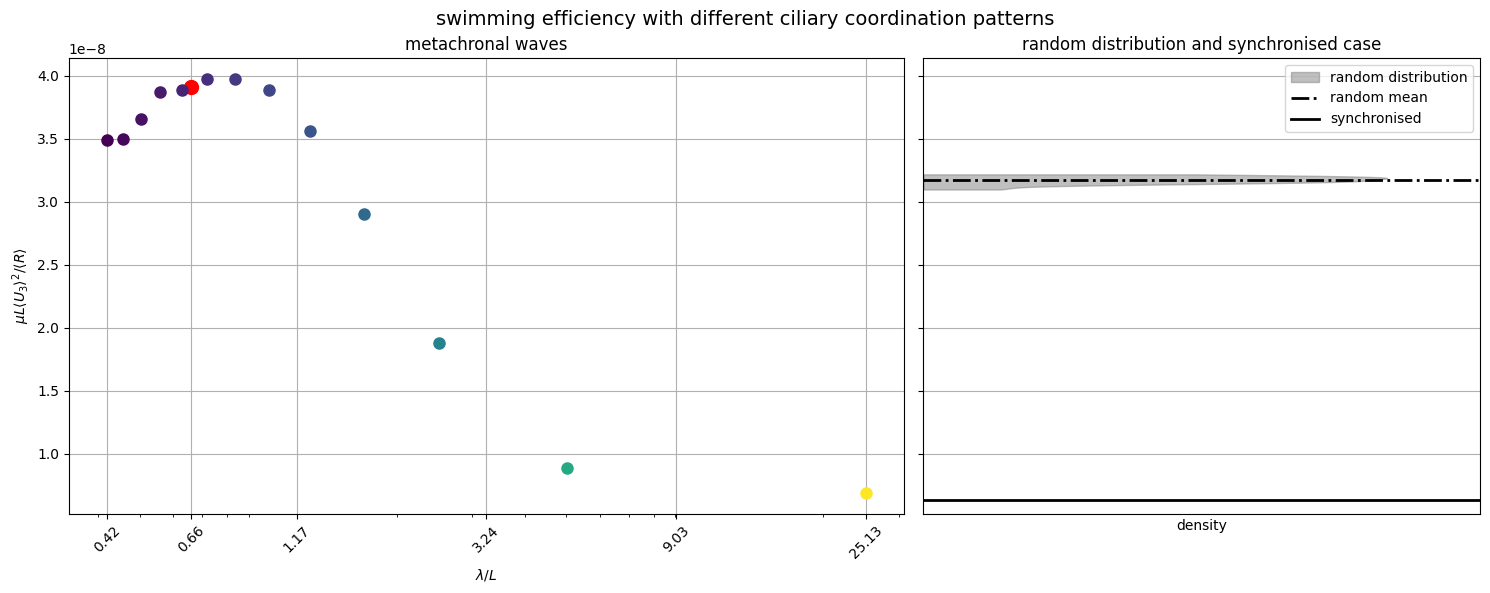

In [ ]:
def compute_speed2_dissipation_ratio(data_dict, energy_dissipation):
    speed2_dissipation_ratio = {}

    for k, data in data_dict.items():
        if k in energy_dissipation and data["body_vel"] is not None:
            # Calculate the norm of the linear velocity
            speed = data["body_vel"]["linear"][:, 2]/49.4
            
            # Calculate the ratio of speed squared to energy dissipation
            speed2_dissipation_ratio[k] = np.mean(speed)**2/np.mean(energy_dissipation[k])

    return speed2_dissipation_ratio

# Compute the speed^2 to dissipation ratio for regular and synchronized cases
speed2_dissipation_ratio = compute_speed2_dissipation_ratio(data_dict_clean, energy_dissipation)

# Compute the speed^2 to dissipation ratio for random cases 
random_speed2_dissipation_ratio = compute_speed2_dissipation_ratio(random_data_dict, random_energy_dissipation)

def plot_speed_dissipation_ratio(speed_dissipation_ratio, random_speed2_dissipation_ratio):
    # Create figure with 2 subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), 
                                  gridspec_kw={'width_ratios': [1.5, 1]},
                                  sharey=True)
    
    # --- MAIN PLOT: Wavelength vs Speed2/Dissipation Ratio ---
    wavelengths = []
    ratios = []
    wavenumbers = []
    
    # Process regular wave cases
    for k in speed_dissipation_ratio.keys():
        if isinstance(k, int) and k > 0:
            wavelength = np.pi * 395.2 / 49.4 / k
            ratio = speed_dissipation_ratio[k]
            
            wavelengths.append(wavelength)
            ratios.append(ratio)
            wavenumbers.append(k)
    
    # Calculate the wavelength for k=38
    wavelength_38 = np.pi * 395.2 / 49.4 / 38
    
    # Create color mapping
    norm = LogNorm(vmin=min(wavelengths), vmax=max(wavelengths))
    cmap = plt.get_cmap('viridis')
    
    # Plot points with colors based on wavelength
    for k, wavelength, ratio in zip(wavenumbers, wavelengths, ratios):
        if k == 38:
            ax1.plot(wavelength, ratio, 'ro', markersize=10)
        else:
            color = cmap(norm(wavelength))
            ax1.plot(wavelength, ratio, 'o', color=color, markersize=8)
    
    # Set log scale for x-axis
    ax1.set_xscale('log')
    
    # Use scientific notation for y-axis
    ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    
    # Get the default ticks that matplotlib would generate
    ax1.set_xticks([])  # Clear current ticks
    ax1.set_xticks(np.logspace(np.log10(min(wavelengths)), np.log10(max(wavelengths)), 5))
    
    # Add k=38 wavelength to the ticks
    locs = list(ax1.get_xticks())
    locs.append(wavelength_38)
    locs = sorted(locs)
    
    # Format the tick labels
    ax1.set_xticks(locs)
    ax1.set_xticklabels([f'{loc:.2f}' for loc in locs], rotation=45)
    
    ax1.set_xlabel(r'$\lambda/L$')
    ax1.set_ylabel(r'$\mu L \langle U_3\rangle^2 / \langle R \rangle$')
    ax1.set_title('metachronal waves')
    ax1.grid(True)
    
    # --- SIDE PLOT: Random Distribution and Synchronized Case ---
    # Process random cases
    if random_speed2_dissipation_ratio:
        random_ratios = list(random_speed2_dissipation_ratio.values())
        random_ratios_array = np.array(random_ratios)
        
        # Calculate mean and std
        random_mean = np.mean(random_ratios_array)
        random_std = np.std(random_ratios_array)
        
        # Calculate kernel density estimation for a smooth distribution
        if len(random_ratios) >= 3:
            density = stats.gaussian_kde(random_ratios_array)
            xs = np.linspace(min(random_ratios_array) - 0.1*random_std, 
                            max(random_ratios_array) + 0.1*random_std, 100)
            ys = density(xs)
            
            # Plot the distribution as a filled curve
            ax2.fill_betweenx(xs, 0, ys, color='gray', alpha=0.5, label='random distribution')
        
        # Add mean line for random distribution
        ax2.axhline(random_mean, color='black', linestyle='-.', linewidth=2, 
                   label='random mean')
    
    # Add synchronized case
    if 0 in speed_dissipation_ratio:
        sync_ratio = speed_dissipation_ratio[0]
        ax2.axhline(sync_ratio, color='black', linestyle='-', linewidth=2, 
                  label='synchronised')
    
    ax2.set_title('random distribution and synchronised case')
    ax2.grid(True, axis='y')
    ax2.set_xlabel('density')
    ax2.set_xticks([])  # Hide x-axis ticks
    ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax2.legend()
    # Set axis limits
    if len(random_ratios_array) >= 3:
        ax2.set_xlim(0, max(ys)*1.2)
    
    # Common title for all subplots
    fig.suptitle('swimming efficiency with different ciliary coordination patterns', fontsize=14)
    
    # Adjust layout
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)  # Make room for suptitle
    
    plt.show()

# Plot the efficiency ratio
plot_speed_dissipation_ratio(speed2_dissipation_ratio, random_speed2_dissipation_ratio)

Here we see that, again, the realistic wavelength is close to a local maxima. We have reason to believe that the small wavelength that _P. dumerilii_ takes on is a hydrodynamically advantageous one. The random cases are all clustered at a point lower in efficiency to the realistic case. The fully synchronised case has the lowest efficiency.